### Program written by Scott Midgley, 2021

Scope: To train and test LR models for band gap energy screening in the configuraional space of MgO-ZnO solid solutions. 

In [1]:
### USER INPUT REQUIRED ###

# Please paste in the path to the repositiory here an comment/uncomment as needed.
# E.g. rundir = r'C:\Users\<user>\Desktop\repository'

# Windows path
#repodir = r'<windows\path\here>'
#repodir = r'C:\Users\smidg\Desktop\ml\repository'

#Unix path
#repodir = '<unix/path/here>'
repodir = r'/home/mts87985/ml-thermo/Machine-Learning-for-Solid-Solutions/'

In [2]:
### USER INPUT REQUIRED ###

# Define percentage of training data to use for training. 
split = 10
#split = 50
#split = 80
#split = 30

In [3]:
# Import modules. 
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import pickle
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import os
from sklearn.linear_model import Lasso

## Load the data

Note we do not shuffle in this case. The data was shuffled when created and we are keeping it un-shuffled here so that the order is the same as that used in the paper. However, you are free to add a shuffle if you like.

In [4]:
# Import data and shuffle (optional).
eners = pd.read_pickle(repodir + 'repository-data/coulomb_matrix/input_data_cme.pkl')
eners = eners.sample(frac=1)
#Calculate mixing energies based on total DFT energy of phase separated end members. Add emix to data frame.  
Emg_end = -381.17925146/32
Ezn_end = -317.49620269/36
Emg_end = 24 * Emg_end
Ezn_end = 8 * Ezn_end
emix = eners['SCF Energy'] - (Emg_end + Ezn_end)
eners['Emix'] = emix

In [5]:
# Split data frame into training, validation, and testing data. 
if split == int(10):
    e_train = eners.iloc[1608:2412] #10% of data for training
elif split == int(30):
    e_train = eners.iloc[1608:4021] #30% of data for training
elif split == int(50):
    e_train = eners.iloc[1608:5630] #50% of data for training
elif split == int(80):
    e_train = eners.iloc[1608:] #80% of data for training
else:
    print('Error: please choose a valid train/test split.')
e_val = eners.iloc[804:1608] #10% of data for validation
e_test = eners.iloc[:804] #10% of data for testing model

In [6]:
# Convert Pandas columns to Numpy arrays. Reshaping to obtain array of nested brackets. 
Xtrain = e_train['Coulomb'].to_numpy()
ytrain = e_train['Emix'].to_numpy()
Xtrain = np.stack(Xtrain)
ytrain= np.stack(ytrain) 
Xval = e_val['Coulomb'].to_numpy()
yval = e_val['Emix'].to_numpy()
Xval = np.stack(Xval)
yval= np.stack(yval)
Xtest = e_test['Coulomb'].to_numpy()
ytest = e_test['Emix'].to_numpy()
Xtest = np.stack(Xtest)
ytest = np.stack(ytest)

In [7]:
# Define Lasso regularizer and train regressor.
lasso_reg = Lasso(alpha=0.0000001)
lasso_reg.fit(Xtrain, ytrain)

/home/mts87985/anaconda3/envs/ml-solid-solns/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012080237290431203, tolerance: 9.764565207508195e-05
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=1e-07)

In [8]:
# Print parameters.
r_sq = (lasso_reg.score(Xtrain, ytrain))
inter = ('intercept: ', lasso_reg.intercept_)
coef = ('coefficient:  ', lasso_reg.coef_)
print(r_sq)
print(inter)
print(coef)

0.9976852814234604
('intercept: ', 6.725708061086589)
('coefficient:  ', array([ 1.52373206e-03,  1.39933363e-04,  4.76241012e-05,  1.22785286e-05,
       -1.55758233e-05, -3.42401938e-05, -7.10156991e-05, -1.20152952e-04,
       -8.42628030e-04,  2.04459113e-03,  2.07295502e-03,  2.23924146e-03,
        2.41300665e-03,  2.57686275e-03,  2.70065304e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.20727721e-03,
        1.17529536e-03,  1.32199276e-03,  5.77268521e-04, -1.15492081e-03,
       -1.17894763e-03, -1.29123722e-03, -1.62259454e-03, -1.80087848e-03,
       -2.16432427e-03, -2.27881118e-03, -2.69753512e-03, -2.95670364e-03,
        1.02840425e-02,  3.18822590e-02,  3.68873235e-02,  3.73324099e-02,
        3.61823994e-02,  3.48271966e-02,  3.61180437e-02,  1.93813392e-02,
        2.46472220e-02,  5.88478505e-02, -0.00000000e+00, -1.79101990e-02,
       -1.50406798e-02, -1.33873554e-02, -2.15777620e-02, -3.58434817e-02,
       -4.16101163e-02, -4.

In [9]:
# Test linear regressor.
ypred = lasso_reg.predict(Xtest)

In [10]:
# Print metric.
mae = (mean_absolute_error(ytest, ypred))
print('mae = ', mae)

mae =  0.0012442348658289275


Text(0, 0.5, 'Regressor')

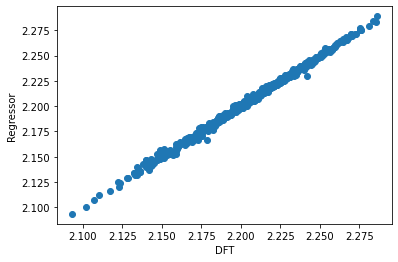

In [11]:
#Plot DFT mixing energy vs regressor predicted.
plt.scatter(ytest, ypred)# plot the predicted versus the actual gaps
plt.xlabel('DFT')
plt.ylabel('Regressor')
#plt.savefig('BGE_pred_vs_val.png')